In [64]:
import hmmlearn.hmm as hmm

observed_returns = np.array(returns_hist_data['Returns'])

# Initialize the HMM with N hidden states
hmm_model = hmm.GaussianHMM(n_components=2, covariance_type="full", n_iter=10000,means_prior=)

# Training the HMM using the Baum-Welch algorithm
hmm_model.fit(observed_returns.reshape(-1,1))

# Estimated parameters
means = hmm_model.means_
covariances = hmm_model.covars_
transition_matrix = hmm_model.transmat_

# Print the estimated parameters
print("Estimated Means for Each Regime:")
print(means)
print("Estimated Covariance Matrices for Each Regime:")
print(covariances)
print("Estimated Transition Probabilities:")
print(transition_matrix)

Estimated Means for Each Regime:
[[-0.01104664]
 [-0.0017613 ]]
Estimated Covariance Matrices for Each Regime:
[[[9.15938507e+02]]

 [[8.42277267e-04]]]
Estimated Transition Probabilities:
[[8.00165846e-08 9.99999920e-01]
 [2.09957145e-07 9.99999790e-01]]


# Dynamic Programming Approach for Single asset

In [89]:
import numpy as np
from scipy.stats import multivariate_normal
def generate_normal_distribution(n):

    L = np.random.rand(n, n)
    cov_matrix = np.dot(L, L.T)

    mean = np.random.randn(n)
    print(mean)
    
    return [mean,cov_matrix]


n = 1
regimes = []
N = 2
T= 50
rf = 0.0154/50
gamma = -1
tpm = np.array([[0.981,0.019],[0.047,0.953]])


regimes = [[[0.00312],[[0.00022]]],[[-0.00175],[[0.00116]]]]

def generate_scenario(prob,t):
    current_regime = np.random.choice(N,p = prob)
    sample = list(np.random.multivariate_normal(mean = regimes[current_regime][0], cov= regimes[current_regime][1]))
    sample.append(rf)
    return np.array(sample)

def generate_monte_carlo_sample():
    sample = []
    curr_regime = np.random.choice(range(N))
    returns = list(np.random.multivariate_normal(mean = regimes[curr_regime][0], cov= regimes[curr_regime][1]))
    returns.append(rf)
    sample.append([curr_regime,returns])
    for i in range(T-1):
        curr_regime = np.random.choice(range(N), p = tpm[curr_regime])
        returns = list(np.random.multivariate_normal(mean = regimes[curr_regime][0], cov= regimes[curr_regime][1]))
        returns.append(rf)
        sample.append([curr_regime,returns])
    
    return sample


generate_monte_carlo_sample()

[[0, [0.010551118794767451, 0.000308]],
 [0, [0.02070535450729936, 0.000308]],
 [0, [-0.009031296532334098, 0.000308]],
 [0, [-0.017161755370205135, 0.000308]],
 [0, [0.0149803427792484, 0.000308]]]

In [90]:
print(regimes[1][:])

[[-0.00175], [[0.00116]]]


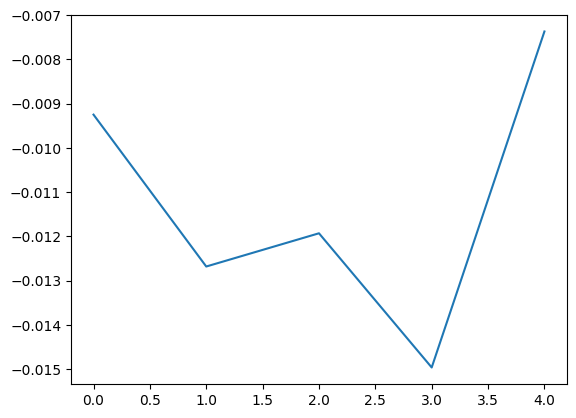

In [91]:
sample_returns = generate_monte_carlo_sample()
import matplotlib.pyplot as plt
x_values = [i for i in range(T)]
y_values = [array[1][0] for array in sample_returns]
regimes_for_this_sample = [array[0] for array in sample_returns]
flig,ax = plt.subplots()
ax.plot(x_values,y_values)
ax.fill_between(x_values,min(y_values),max(y_values),where = [regimes_for_this_sample[i]==1 for i in range(T)],color = 'grey',alpha = 0.5)
plt.show()

## Probabilty set initialization over different regimes

In [92]:
from itertools import product
from scipy.optimize import minimize
discrete_prob = 50
prob_set = []
for i in range(discrete_prob+1):
    prob_set.append(1/(discrete_prob)*i)

combinations = product(prob_set, repeat=N)
possible_probabities = [vector for vector in combinations if sum(vector) == 1]
reverse_index = {}
for _,p in enumerate(possible_probabities):
    reverse_index[p]= _

possible_probabities = [np.array(x) for x in possible_probabities]


In [93]:
delta_pi = 0.01
pi_set = []
curr_pi = -1
while curr_pi<=1+1e-5:
    pi_set.append(curr_pi)
    curr_pi+=delta_pi

pi_combinations = product(pi_set,repeat=n)
possible_pi = [np.append(np.array(vector),1-np.sum(vector)) for vector in pi_combinations]


In [94]:
print(possible_pi[-1])

[ 1.00000000e+00 -1.33226763e-15]


In [95]:
def closest_probability_distn(p_in):
    lowest_norm = float('inf')  
    ind = 0
    
    for _,array in enumerate(possible_probabities):
        norm = np.linalg.norm(p_in - array) 
        if norm < lowest_norm:
            lowest_norm = norm
            closest_array = array
            ind = _

    return ind,closest_array

def updateBelief(r,p):
    #print(r,p)
    p_new = []
    #print(r)
    r = r[:-1]
    density = np.zeros(N);
    for i in range(N):
        mvn = multivariate_normal(mean=regimes[i][0], cov = regimes[i][1])
        density[i]= mvn.pdf(r)

    p_new = np.zeros(N)
    for i in range(N):
        for j in range(N):
            p_new[i]+= density[j]*tpm[j][i]*p[j]

    p_new/=np.sum(p_new)
    closest_p_ind,_ = closest_probability_distn(p_new)
    return p_new,closest_p_ind

def newWealth(r, pi):
    W_new = 0
    for i in range(n+1):
        W_new+= pi[i]*(1+r[i])
    return W_new

In [96]:
V = {}
for _ in range(len(possible_probabities)):
    V[(_,T)] = (1**gamma)/gamma

t = T-1
M = 20
pi_l = -1.0
pi_u = 1.0

   
optimal_pi_star = {}

# scenarios = []_star = {}
for iter in range(1):
#     scenarios = []
#     for j in range(M):
#         sample = generate_monte_carlo_sample()
#         scenarios.append(sample)
#     print("Samples generated")
    t = T-1
    while (t>=0):
        #returns_at_this_time = [scenarios[i][t][1] for i in range(M)]
        #print(returns_at_this_time)
        for _ in range(len(possible_probabities)):
            returns_at_this_time = []
            for j in range(M):
                sample = generate_scenario(possible_probabities[_],t)
                returns_at_this_time.append(sample)
            def objective_function(pi):
                return np.average([(newWealth(returns_at_this_time[i],pi)**gamma)*V[(updateBelief(returns_at_this_time[i],possible_probabities[_])[1],t+1)] for i in range(M)])

            constraints = ([{'type': 'eq', 'fun': lambda pi: np.sum(pi) - 1}])  # Example constraint: pi sums to 1

            #Initial guess for pi (dimension n)
            initial_pi_guess = np.ones(n+1) 
            initial_pi_guess/=np.sum(initial_pi_guess)# Starting with equal weights

            #Minimize the negative of the objective function to maximize
            pi_star = minimize(lambda x: (-1)*objective_function(x),  initial_pi_guess,
                               constraints=constraints,
                                bounds = [(pi_l,pi_u) for i in range(n)] + [(None,None)]
                                 )

            #pi_star = max(possible_pi,key = objective_function)
            print(pi_star.message)
            pi_star = pi_star.x
            V[(_,t)] = np.average([(newWealth(returns_at_this_time[i],pi_star)**gamma)*V[(updateBelief(returns_at_this_time[i],possible_probabities[_])[1],t+1)] for i in range(M)])
            optimal_pi_star[(_,t)] = pi_star
            print(iter,t,possible_probabities[_],pi_star)

        t= t-1
        print("\n")



Optimization terminated successfully
0 4 [0. 1.] [-1.  2.]
Optimization terminated successfully
0 4 [0.02 0.98] [ 1.00000000e+00 -8.32667268e-17]
Optimization terminated successfully
0 4 [0.04 0.96] [-1.  2.]
Optimization terminated successfully
0 4 [0.06 0.94] [1. 0.]
Optimization terminated successfully
0 4 [0.08 0.92] [ 1.00000000e+00 -1.66533454e-16]
Optimization terminated successfully
0 4 [0.1 0.9] [-1.  2.]
Optimization terminated successfully
0 4 [0.12 0.88] [-1.  2.]
Optimization terminated successfully
0 4 [0.14 0.86] [-1.  2.]
Optimization terminated successfully
0 4 [0.16 0.84] [1.00000000e+00 1.11022302e-16]
Optimization terminated successfully
0 4 [0.18 0.82] [1. 0.]
Optimization terminated successfully
0 4 [0.2 0.8] [1. 0.]
Optimization terminated successfully
0 4 [0.22 0.78] [1. 0.]
Optimization terminated successfully
0 4 [0.24 0.76] [1.00000000e+00 1.66533454e-16]
Optimization terminated successfully
0 4 [0.26 0.74] [-1.  2.]
Optimization terminated successfully
0 4 [

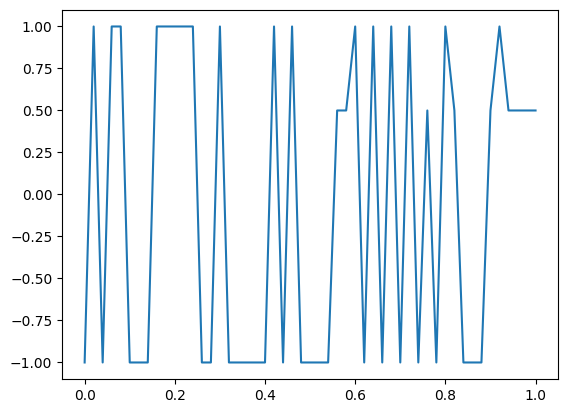

[array([-1.,  2.]), array([-1.,  2.]), array([1.00000000e+00, 5.55111512e-17]), array([-0.36952683,  1.36952683]), array([1.00000000e+00, 1.11022302e-16])]


In [97]:
import matplotlib.pyplot as plt

xpoints = [x[0] for x in possible_probabities]
ypoints = [optimal_pi_star[_,4][0] for _ in range(len(possible_probabities))]

plt.plot(xpoints,ypoints)
plt.show()

print([optimal_pi_star[_,0] for _ in range(5)])

In [98]:
for _ in range(len(possible_probabities)):
    print(possible_probabities[_])
    print(V[(_,0)])

[0. 1.]
-0.9703120971236316
[0.02 0.98]
-0.9649064725394906
[0.04 0.96]
-0.9637222846505207
[0.06 0.94]
-0.9716339981856297
[0.08 0.92]
-0.9666141899248023
[0.1 0.9]
-0.968770455590054
[0.12 0.88]
-0.9750847021311756
[0.14 0.86]
-0.9736978692782667
[0.16 0.84]
-0.9718332243811576
[0.18 0.82]
-0.9634013192750324
[0.2 0.8]
-0.9649596933811726
[0.22 0.78]
-0.9708525359277292
[0.24 0.76]
-0.9692426107775921
[0.26 0.74]
-0.9752530508729285
[0.28 0.72]
-0.9784093856926607
[0.3 0.7]
-0.9754056612003487
[0.32 0.68]
-0.9693197626256206
[0.34 0.66]
-0.9743462749443579
[0.36 0.64]
-0.9684339672890181
[0.38 0.62]
-0.9725941924089618
[0.4 0.6]
-0.9733388573206472
[0.42 0.58]
-0.9705967578089616
[0.44 0.56]
-0.9790313228715238
[0.46 0.54]
-0.977302743563165
[0.48 0.52]
-0.975200015076686
[0.5 0.5]
-0.9802412114039978
[0.52 0.48]
-0.9796625254424309
[0.54 0.46]
-0.9752856586769715
[0.56 0.44]
-0.9813663433489465
[0.58 0.42]
-0.9762281386755243
[0.6 0.4]
-0.9810664167096681
[0.62 0.38]
-0.974879014170

# Neural Network using Dynamic Program solution as a startpoint

In [104]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers


In [105]:
def closest_probability_distn_TF(p_in):
    lowest_norm = float('inf')  # Set to positive infinity initially
    ind = 0
    p_in = p_in.numpy()  # Convert to NumPy array
    p_in_tf = tf.convert_to_tensor(p_in, dtype=tf.float32)  # Convert back to TensorFlow tensor

    # Iterate through the set and calculate the norm for each element
    for i, array in enumerate(possible_probabities):
        array_tf = tf.convert_to_tensor(array, dtype=tf.float32)
        norm = tf.norm(p_in_tf - array_tf, ord='euclidean')  # Calculate the Euclidean norm
        if norm < lowest_norm:
            lowest_norm = norm
            closest_array = array
            ind = i

    return ind, closest_array

99
1000


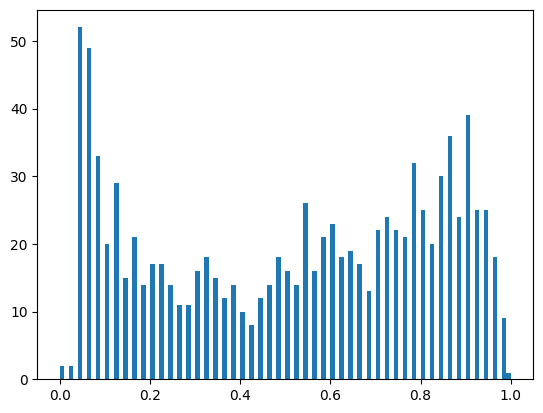

tf.Tensor(0.0010943882, shape=(), dtype=float32)
tf.Tensor(0.0010758794, shape=(), dtype=float32)
tf.Tensor(0.0010574542, shape=(), dtype=float32)
tf.Tensor(0.0010435198, shape=(), dtype=float32)
tf.Tensor(0.001029564, shape=(), dtype=float32)
tf.Tensor(0.0010180519, shape=(), dtype=float32)
tf.Tensor(0.0010091402, shape=(), dtype=float32)
tf.Tensor(0.0009993333, shape=(), dtype=float32)
tf.Tensor(0.0009989364, shape=(), dtype=float32)
tf.Tensor(0.0009953846, shape=(), dtype=float32)


In [110]:
import tensorflow as tf
import numpy as np


transaction_rate = 0.015
crra_coefficient = -1  

def newWealthWithTC(W, r, pi_pre, pi_new):
    W_new = tf.reduce_sum(W * pi_pre * (1 + r))
    W_new = W_new - W_new * transaction_rate * tf.norm(pi_new - pi_pre, ord=1)
    return W_new


def custom_loss(initial_wealth, initial_portfolio, upper_b, lower_b, returns):
    input_size = tf.shape(upper_b)[0]
    total_loss = 0.0

    for _ in range(input_size):
        wealth = [tf.constant([initial_wealth], dtype=tf.float32)]
        portfolio = [tf.constant(initial_portfolio, dtype=tf.float32)]

        for i in range(T):
            w = wealth[-1]
            pi = portfolio[-1]
            pi_new = tf.identity(pi)[:-1]

            closest_p_ind, __ = closest_probability_distn_TF(input_data[_, i])
            pi_star = tf.convert_to_tensor(optimal_pi_star[(closest_p_ind, i)],dtype = tf.float32)
            
            pi_star = pi_star[:-1]
            u_b = upper_b[_, i]
            l_b = lower_b[_, i]
            u_b = tf.minimum(tf.ones(n, dtype=tf.float32), pi_star + u_b)
            l_b = tf.maximum(-tf.ones(n, dtype=tf.float32), pi_star - l_b)
           
            pi_new = tf.maximum(l_b, tf.minimum(u_b, pi_new))
            risk_free_allocation = 1 - tf.reduce_sum(pi_new)
            pi_new = tf.concat([pi_new, [risk_free_allocation]], axis=0)
            
            portfolio.append(pi_new)

            new_wealth = newWealthWithTC(w, returns[_][i], pi, pi_new)
            wealth.append(new_wealth)
        
        loss = -((wealth[-1] ** crra_coefficient) / crra_coefficient) 
        
        total_loss += loss

    return total_loss / tf.cast(input_size, dtype=tf.float32)


class CustomRNNCell(tf.keras.layers.Layer):
    
    def __init__(self, output_size):
        super(CustomRNNCell, self).__init__()
        #self.fc1 = tf.keras.layers.Dense(n, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))
        self.fc1 = tf.keras.Sequential()
        self.fc1.add(tf.keras.layers.Dense(20, activation='relu')
        self.fc1.add(tf.keras.layers.Dense(40, activation='relu')
        self.fc1.add(tf.keras.layers.Dense(80, activation='relu')
        self.fc1.add(tf.keras.layers.Dense(n, activation='relu')
                     
                     
        #self.fc2 = tf.keras.layers.Dense(n, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))
        self.fc2 = tf.keras.Sequential()
        self.fc2.add(tf.keras.layers.Dense(20, activation='relu')
        self.fc2.add(tf.keras.layers.Dense(40, activation='relu')
        self.fc2.add(tf.keras.layers.Dense(80, activation='relu')
        self.fc2.add(tf.keras.layers.Dense(n, activation='relu')

    def call(self, x):
        out_l = self.fc1(x)
        out_u = self.fc2(x)
        return out_l, out_u

n_samples = 200
input_data = []
return_samples= []
cnt0 = 0
plot_x = []
for i in range(n_samples):
    sample = generate_monte_carlo_sample()
    if(sample[0][0]==0):
        cnt0+=1
    returns_for_this_sample = []
    for time in range(T):
        returns_for_this_sample.append(sample[time][1])
    return_samples.append(returns_for_this_sample)
    #return_samples.append()
    initial_p = np.random.rand(N)
    initial_p/=np.sum(initial_p)
    initial_p = closest_probability_distn(initial_p)[1]
    plot_x.append(initial_p[0])
    input_to_rnn = [initial_p]
    for time in range(T-1):
        p = input_to_rnn[-1]
        p_new,__ = updateBelief(sample[time][1],p)
        p_new = closest_probability_distn(p_new)[1]
        plot_x.append(p_new[0])
        input_to_rnn.append(p_new)
    input_data.append(input_to_rnn)

print(cnt0)
print(len(plot_x))
import matplotlib.pyplot as plt
plt.hist(plot_x,bins = 100)
plt.show()

input_data = tf.constant(input_data, dtype=tf.float32)
return_samples = tf.constant(return_samples, dtype=tf.float32)
# Create the RNN cell and optimizer
input_size = N
output_size = n
rnn_cell_57 = CustomRNNCell(output_size)

initial_learning_rate = 0.1  # Initial learning rate
first_decay_steps = 1000   # Number of steps before the first decay
t_mul = 2.0              # Multiplier for subsequent restarts
m_mul = 0.95             # Decay factor for subsequent restarts
alpha = 0.0              # Minimum learning rate

learning_rate = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=initial_learning_rate,
    first_decay_steps=first_decay_steps,
    t_mul=t_mul,
    m_mul=m_mul,
    alpha=alpha,
)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)


#Training loop
for iter in range(10):
    with tf.GradientTape() as tape:
        lb, ub = rnn_cell_57(input_data)
        initial_wealth = 1000
        initial_portfolio = np.random.rand(n + 1).astype(np.float32)
        initial_portfolio /= np.sum(initial_portfolio)
        loss = custom_loss(initial_wealth, initial_portfolio, ub, lb, return_samples)

    gradients = tape.gradient(loss, rnn_cell_57.trainable_variables)
    optimizer.apply_gradients(zip(gradients, rnn_cell_57.trainable_variables))

    print(loss)


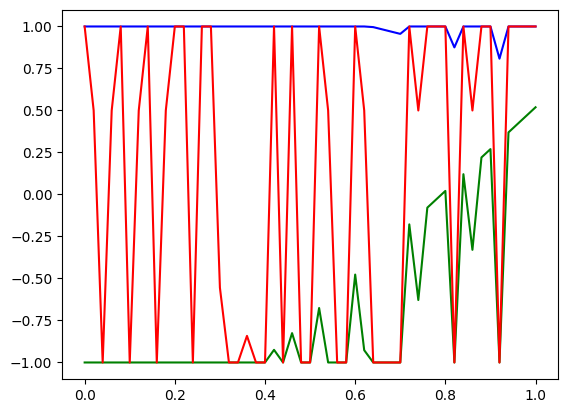

In [111]:
import matplotlib.pyplot as plt
x_values = []
upper_b = []
lower_b = []
portfolio_values = []
for p in possible_probabities:
    p_normal = p[0]
    x_values.append(p_normal)
    pi_star = optimal_pi_star[(reverse_index[tuple(p)],2)]
    portfolio_values.append(pi_star[0])
    l_b,u_b = rnn_cell_57(tf.constant([[p]*T],dtype = tf.float32))
    #print(p,l_b[0][1][0],u_b[0][1][0])
    lower_b.append(max(-1.0,(pi_star[0]-l_b[0][2][0])))
    upper_b.append(min(1.0,(pi_star[0]+u_b[0][2][0])))
    
plt.plot(x_values,lower_b,color= 'g')
plt.plot(x_values,upper_b,color = 'b')
plt.plot(x_values,portfolio_values,color = 'r')
plt.show()

In [ ]:
import torch
import torch.nn as nn

# Define the RNN parameters
input_size = 10  # Input feature size
hidden_size = 20  # Hidden state size
num_layers = 2  # Number of RNN layers
sequence_length = 5  # Length of the input sequence
batch_size = 3  # Number of sequences in a batch

# Create sample input data
input_data = torch.randn(batch_size, sequence_length, input_size)

# Define the RNN layer
rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)

# Pass the input data through the RNN
output, hidden = rnn(input_data)

# 'output' contains the output at each time step
# 'hidden' contains the hidden state at the final time step

# Print the shapes of output and hidden
print("Output shape:", output.shape)
print("Hidden shape:", hidden.shape)


# Hidden Markov Model to estimate the parameters of stcok market

import numpy as np
import pandas as pd
path = "../Dataset/RELIANCE.NS.csv"
prices_hist_data = pd.read_csv(path)
prices_hist_data = prices_hist_data.dropna()
prices_hist_data = prices_hist_data.reset_index(drop=True)
prices_hist_data

In [ ]:
returns_hist_data = {}
total_data_time = len(prices_hist_data)
returns_hist_data[prices_hist_data['Date'][0]] = 0
prev_price = float(prices_hist_data['Adj Close'][0])

for i in range(1,total_data_time):
    curr_price = float(prices_hist_data['Adj Close'][i])
    returns_hist_data[prices_hist_data['Date'][i]] = (curr_price-prev_price)/prev_price
    prev_price = curr_price

returns_hist_data = pd.DataFrame(data=returns_hist_data.items(),columns=['Date','Returns'])
print(returns_hist_data)